### Fig input range (Fig 3)
- 3A: low-input experiment
- 3B: standard input experiment

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0)

sys.path.append('../scripts/')
from plot_helpers import *
import analyze_qpcr_plate

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Make outdir and load the data
outdir = '../figures/F3/'
os.makedirs(outdir, exist_ok = True)

In [4]:
qpcr_dir = os.path.join(results_dir, 'qPCR_data')

#0.5 ng and 100 ng input in 10 ul rxn
low_input_data = ['191021_lotitration_1/20191021_111019_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']
low_input_template  = ['191021_lotitration_1/qPCR_analysis_template_lotitration_1.xlsx']

#100 ng and 1 ug input in 50 ul rxn
mid_input_data = ['191023_hititration_1/20191023_131420_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']
mid_input_template = ['191023_hititration_1/qPCR_analysis_template_hititration_1.xlsx']

#5 ug input in 40 ul rxn -- this served as the pre-sequencing QC as well.
hi_input_data = ['prep_1_190911/20190911_151311_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx', 
                  'prep_2_3_190912/20190912_122407_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']

hi_input_template = ['prep_1_190911/qPCR_analysis_template_prep1.xlsx',
                      'prep_2_3_190912/qPCR_analysis_template_prep2_3.xlsx']

low_input = {'data': [os.path.join(qpcr_dir, i) for i in low_input_data], 
        'templates': [os.path.join(qpcr_dir, i) for i in low_input_template]}

mid_input = {'data': [os.path.join(qpcr_dir, i) for i in mid_input_data], 
        'templates': [os.path.join(qpcr_dir, i) for i in mid_input_template]}

hi_input = {'data': [os.path.join(qpcr_dir, i) for i in hi_input_data], 
        'templates': [os.path.join(qpcr_dir, i) for i in hi_input_template]}

In [5]:
def analyze_plate_w_reps(data_file, template_file, ctrl_primer):
    #In this case, the replicates are specified in the sample and not by the position in the plate list
    df = analyze_qpcr_plate.main(data_file, template_file, ctrl_primer)
    df['rep'] = df.index.get_level_values('sample').map(lambda x: int(x.split('_')[-1].split('r')[-1]))

    #get the sample name with no replicate annotation
    df['sample_base'] = df.index.get_level_values('sample').map(lambda x: '_'.join(x.split('_')[0:-1]))
    df['percent_remaining'] = df['fold_change']*100
    return df

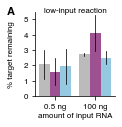

In [6]:
#3A low input, 10 ul hyb reaction
#https://stackoverflow.com/questions/5735208/remove-the-legend-on-a-matplotlib-figure
panel_name = '3A'
plot = Plotter(corners = [0.24, 0.24, 0.71, 0.71], figsize = (sfig, sfig))
plot.nudge_corners(left = True, right = True)
plot.setup_axis()
low_df = analyze_plate_w_reps(low_input['data'][0], low_input['templates'][0], 'act5c')
plot.ax = sns.barplot(x="sample_base", y="percent_remaining", hue="primer", data = low_df.reset_index(), 
                      ci = 'sd', ax = plot.ax)
plot.set_ylabel('% target remaining')
plot.set_xlabel('amount of input RNA')
plot.add_letter('A')
plot.ax.set_xticklabels(['0.5 ng', '100 ng'])
plot.ax.set_ylim(0, 5.5)
leg = plot.ax.get_legend().set_visible(False)
plot.ax.text(0.5, 0.99, 'low-input reaction', ha = 'center', transform = plot.ax.transAxes, fontsize = label_fontsize)
plot.ax.yaxis.set_major_locator(loc)
#seaborn is not respecting rcparams for linewidth, so change it here:
lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')
plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

In [7]:
#Combine the data from the mid-range and high-range experiments that were used with the standard protocol
mid_df = analyze_plate_w_reps(mid_input['data'][0], mid_input['templates'][0], 'act5c')
hi_df1 = analyze_plate_w_reps(hi_input['data'][0], hi_input['templates'][0], 'Act5c')
hi_df2 = analyze_plate_w_reps(hi_input['data'][1], hi_input['templates'][1], 'Act5c')
standard_df = pd.concat([mid_df, hi_df1, hi_df2])
standard_df = standard_df[standard_df['sample_base'] != 'PD_100ng'].copy()
standard_df = standard_df.loc[pd.IndexSlice[['18S', '28L', '28R'], :, :],].copy()

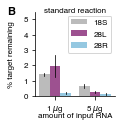

In [8]:
#3B, standard input 40 or 50 ul reaction
panel_name = '3B'
plot = Plotter(corners = [0.24, 0.24, 0.71, 0.71], figsize = (sfig, sfig))
plot.nudge_corners(left = True, right = True)
plot.setup_axis()
plot.ax = sns.barplot(x="sample_base", y="percent_remaining", hue="primer", data = standard_df.reset_index(), 
                      ci = 'sd', ax = plot.ax)
plot.set_ylabel('% target remaining')
plot.set_xlabel('amount of input RNA')
plot.add_letter('B')
plot.ax.set_xticklabels([r'1 $\mu$g', r'5 $\mu$g'])
plot.ax.set_ylim(0, 5.5)
plot.ax.text(0.5, 0.99, 'standard reaction', ha = 'center', transform = plot.ax.transAxes, fontsize = label_fontsize)
plot.ax.yaxis.set_major_locator(loc)
plt.legend(loc = 'best', ncol = 1, fontsize = label_fontsize)
#seaborn is not respecting rcparams for linewidth, so change it here:
lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')
plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

In [9]:
#Report the depletion values for the low-input protocol
low_df.groupby(['sample_base', 'primer'])['percent_remaining'].mean()

sample_base  primer
PD_0.5ng     18S       2.067452
             28L       1.597553
             28R       1.932985
PD_100ng     18S       2.706467
             28L       4.080252
             28R       2.488393
Name: percent_remaining, dtype: float64

In [10]:
#Report the depletion values for the standard input protocol
standard_df.groupby(['sample_base', 'primer'])['percent_remaining'].mean()

sample_base  primer
PD_1ug       18S       1.407902
             28L       1.955633
             28R       0.180138
PD_5ug       18S       0.669514
             28L       0.247320
             28R       0.140421
Name: percent_remaining, dtype: float64